In [2]:
%matplotlib notebook

In [3]:
from scipy.io.matlab import loadmat
import skrf as rf
import numpy as np
from numpy import sqrt, abs, pi, exp
import matplotlib.pyplot as plt
rf.stylely('skrf_wide.mplstyle')

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


The functions below are used to calculate the coupling resistances of the RDLs:

In [6]:
def calculate_Xs(f_MHz):
    """
    Xs from interpolation (from Walid)
    """
    p1Xs = 0.000102
    p2Xs = -0.007769
    p3Xs = 0.724653
    p4Xs = -3.175984
    Xs   = p1Xs*f_MHz**3 + p2Xs*f_MHz**2 + p3Xs*f_MHz**1 + p4Xs
    return Xs

In [19]:
def interp_cables(nwk):
    """
    Interpolate then return the voltage probe loss Kc to the network frequencies
    
    Parameters
    -----------
    - nwk : skrf.Network
    
    Return
    -----------
    - Kc: np.array (nbFreq,4)
        Cable transmission coefficients at interpolated frequencies
    
    """
    # RF probe cables
    cable1 = rf.Network('Sparameters/Voltage Probes/CableProbe1.s2p', f_unit='MHz')
    cable2 = rf.Network('Sparameters/Voltage Probes/CableProbe2.s2p', f_unit='MHz')
    cable3 = rf.Network('Sparameters/Voltage Probes/CableProbe3.s2p', f_unit='MHz')
    cable4 = rf.Network('Sparameters/Voltage Probes/CableProbe4.s2p', f_unit='MHz')
    # Need to interpolate the networks into the frequency subdomain of the antenna 
    cable1_interp = cable1.interpolate(nwk.frequency)
    cable2_interp = cable2.interpolate(nwk.frequency)
    cable3_interp = cable3.interpolate(nwk.frequency)
    cable4_interp = cable4.interpolate(nwk.frequency)
    #print(cable1, '\n->\n', cable1_interp)
    # Kc : cables transmission coeff from from measurements
    Kc = np.c_[1/cable1_interp.s[:,1,0],
               1/cable2_interp.s[:,1,0],
               1/cable3_interp.s[:,1,0],
               1/cable4_interp.s[:,1,0]]
    return Kc

In [16]:
def extract_Rc(network, A, f0):
    """
    Parameters
    ----------
    - network: skrf Network
    - A: np.array (4,)
        excitation vector ex: (+1, -1, 0, 0) 
    - f0: scalar
        RF frequency of interest
    
    Return
    ----------
    - R: np.array (nbFreq, 2)
        Coupling Resistances for all frequencies
    """
    # antenna response :
    B = network.s @ A
    Xs = calculate_Xs(network.f/1e6)
    
    # Kv : probes transmission coeff
    Kv_dB = np.r_[81.82, 81.98, 82.42, 83.50] #  @ 55.5 MHz

    # extrapolate vs frequency the probe trans coeff
    Kv = np.tile(network.f/f0, (4,1)).T * np.transpose(10**(Kv_dB/20) * exp(-pi/2*1j))

    # cable loss
    Kc = interp_cables(network)
    
    V1 = Kv[:,0]*Kc[:,0]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
    V2 = Kv[:,1]*Kc[:,1]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
    V3 = Kv[:,2]*Kc[:,2]*sqrt(50)*B[:,2] # (S(3,1)*a1+S(3,2)*a2);
    V4 = Kv[:,3]*Kc[:,3]*sqrt(50)*B[:,3] # (S(4,1)*a1+S(4,2)*a2);
    V = np.c_[V1, V2, V3, V4]

    P = 0.5*(abs(A[0:2])**2 - abs(B[:,0:2])**2)

    VmL = sqrt((abs(V1)**2 + abs(V2)**2)/2)
    VmR = sqrt((abs(V3)**2 + abs(V4)**2)/2)
    RL  =  Xs**2 * P[:,0] / VmL**2
    RR  =  Xs**2 * P[:,1] / VmR**2
    R = np.c_[RL, RR]
    
    return R

# S-parameter of the manually matched IC3 antenna

In the example below, we illustrate the antenna behaviour when each side is separatly matched (the other side capacitor being setup at their maximum values) 

In [21]:
left_sol1 = rf.Network('Sparameters/LowPowerTestsAquarium/Left/Matching_every_Daq/IC3_Left_55p5MHz_DaqMLarge_2.s4p', f_unit='MHz')
left_sol2 = rf.Network('Sparameters/LowPowerTestsAquarium/Left/Matching_every_Daq/IC3_Left_55p5MHz_DaqMLarge_4.s4p', f_unit='MHz')

right_sol1 = rf.Network('Sparameters/LowPowerTestsAquarium/Right/Matching_every_Daq/IC3_Right_55p5MHz_DaqMLarge_2.s4p', f_unit='MHz')
right_sol2 = rf.Network('Sparameters/LowPowerTestsAquarium/Right/Matching_every_Daq/IC3_Right_55p5MHz_DaqMLarge_4.s4p', f_unit='MHz')


## Left side

<IPython.core.display.Javascript object>


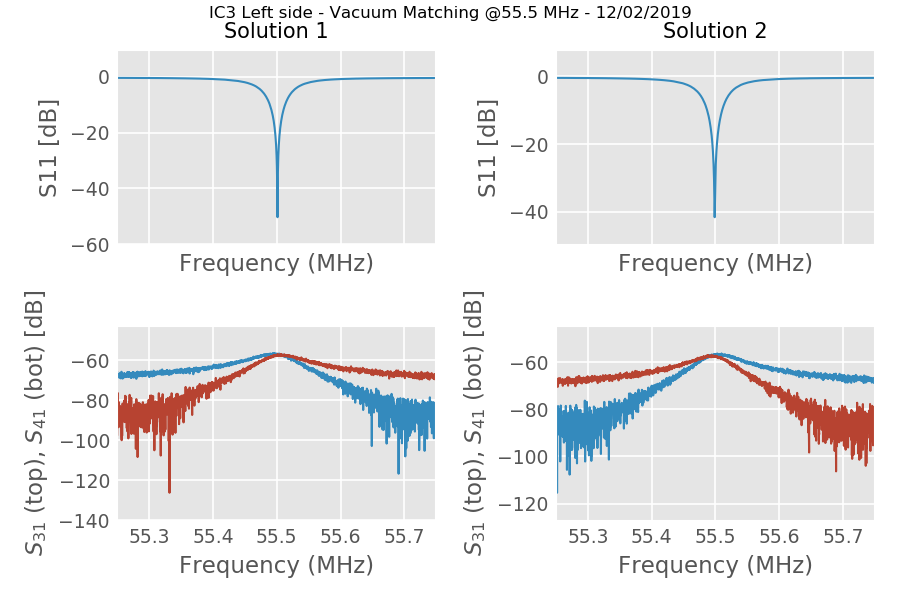

In [25]:
fig, axes = plt.subplots(2, 2, sharex=True)
# Left side - solution 1
left_sol1.plot_s_db(m=0, n=0, ax=axes[0,0], show_legend=False, y_label='S11 [dB]')
left_sol1.plot_s_db(m=2, n=0, ax=axes[1,0], show_legend=False)
left_sol1.plot_s_db(m=3, n=0, ax=axes[1,0], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')
# Left side - solution 2
left_sol2.plot_s_db(m=0, n=0, ax=axes[0,1], show_legend=False, y_label='S11 [dB]')
left_sol2.plot_s_db(m=2, n=0, ax=axes[1,1], show_legend=False)
left_sol2.plot_s_db(m=3, n=0, ax=axes[1,1], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')


fig.suptitle('IC3 Left side - Vacuum Matching @55.5 MHz - 12/02/2019', fontsize=8, y=0.99)
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)
fig.tight_layout()
fig.savefig('IC3_Left_Matched55.5MHz.png', dpi=600)


## Right side

<IPython.core.display.Javascript object>


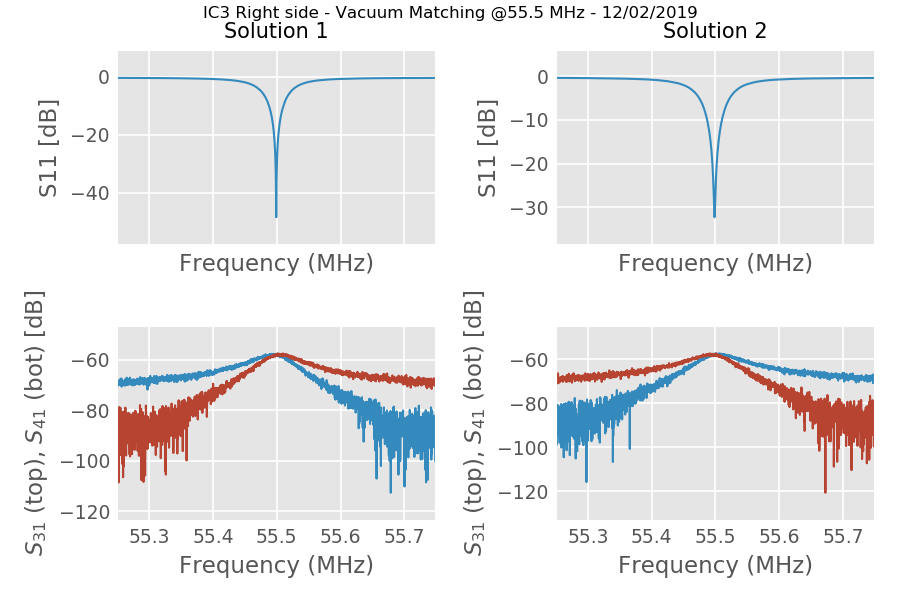

In [24]:
fig, axes = plt.subplots(2, 2, sharex=True)
# Right side - solution 1
right_sol1.plot_s_db(m=1, n=1, ax=axes[0,0], show_legend=False, y_label='S11 [dB]')
right_sol1.plot_s_db(m=2, n=1, ax=axes[1,0], show_legend=False)
right_sol1.plot_s_db(m=3, n=1, ax=axes[1,0], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')
# Left side - solution 2
right_sol2.plot_s_db(m=1, n=1, ax=axes[0,1], show_legend=False, y_label='S11 [dB]')
right_sol2.plot_s_db(m=2, n=1, ax=axes[1,1], show_legend=False)
right_sol2.plot_s_db(m=3, n=1, ax=axes[1,1], show_legend=False, y_label='$S_{31}$ (top), $S_{41}$ (bot) [dB]')

fig.suptitle('IC3 Right side - Vacuum Matching @55.5 MHz - 12/02/2019', fontsize=8, y=0.99)
axes[0,0].set_title('Solution 1', fontsize=10)
axes[0,1].set_title('Solution 2', fontsize=10)
fig.tight_layout()
fig.savefig('IC3_Right_Matched55.5MHz.png', dpi=600)


# Coupling Resistance vs aquarium distance

In the following, we extract the coupling resistances of both antenna side, versus the distance to the salted water aquarium. In this situation, the antenna is matched at each positions, and the precise match frequency is extracted from the Scattering parameters.

In [176]:
#f0 = 55.5e6  # automatically fetched
Daqs = range(11)  # 0 to 10 cm

Rc_left, Rc_right = [], []
for side in ['Left', 'Right']:
    for Daq in Daqs:
        for sol in [2,4]:
            file = f'Sparameters/LowPowerTestsAquarium/{side}/Matching_every_Daq/IC3_{side}_55p5MHz_DaqM{Daq:02.0f}p0cm_{sol}.s4p'
            ntw = rf.Network(file)
            
            # determine la frequence de match à partir du min de S11 à gauche (S22 à droite)
            # calcule la resistance de couplage pour les deux solutions
            if side == 'Left':
                idx = np.argmin(np.abs(ntw.s[:,0,0]))
                f0 = ntw.f[idx]
                A = np.r_[1, 0, 0, 0]
                Rcs = extract_Rc(ntw, A, f0)
                Rc_left.append(Rcs[idx])           
            elif side == 'Right':
                idx = np.argmin(np.abs(ntw.s[:,1,1]))
                f0 = ntw.f[idx]                
                A = np.r_[0, 1, 0, 0]
                Rcs = extract_Rc(ntw, A, f0)
                Rc_right.append(Rcs[idx])
                    
Rc_left = np.array(Rc_left)[:,0].reshape(-1,2)
Rc_right = np.array(Rc_right)[:,1].reshape(-1,2)

<IPython.core.display.Javascript object>


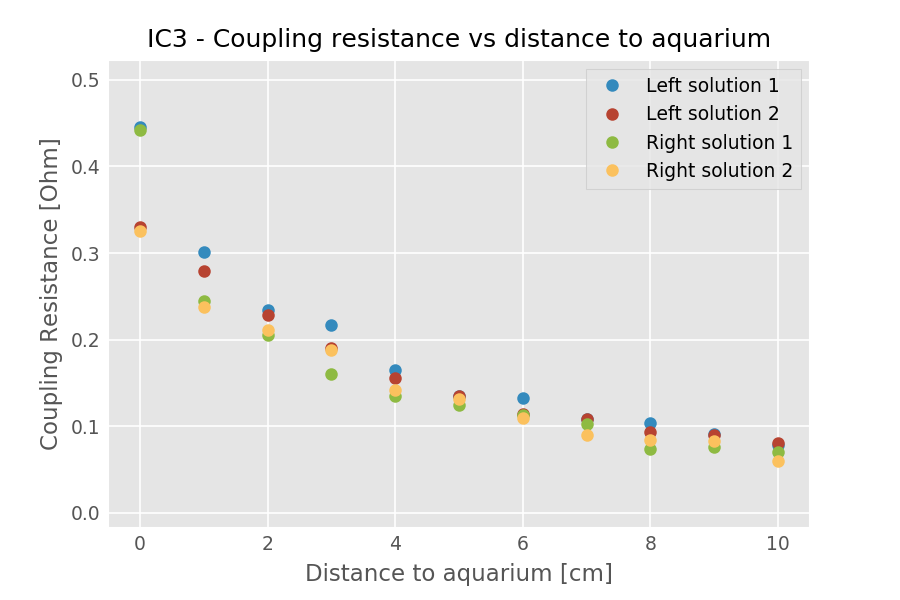

In [177]:
fig, ax = plt.subplots()

ax.plot(Daqs, Rc_left[:,0], '.', ms=10, label='Left solution 1')
ax.plot(Daqs, Rc_left[:,1], '.', ms=10, label='Left solution 2')
ax.plot(Daqs, Rc_right[:,0], '.', ms=10, label='Right solution 1')
ax.plot(Daqs, Rc_right[:,1], '.', ms=10, label='Right solution 2')
ax.legend()
ax.set_xlim(-0.5,10.5)
yticks=ax.get_yticks()
ax.set_xlabel('Distance to aquarium [cm]')
ax.set_ylabel('Coupling Resistance [Ohm]')
ax.set_title('IC3 - Coupling resistance vs distance to aquarium', fontsize=12)
ax.grid(True, which='minor')

In [178]:
fig.savefig('IC3_Rc_vs_Daq.png', dpi=150)

# Load Resilience

In [441]:
import pandas as pd

In [549]:
# from a file list, extract the matching frequency, coupling resistances and VSWR to fill the excel table
def to_dataframe(files, Daqs, f0=55.5e6, side='Left', sol='Quad4', at_match=False):

    VSWR, Rc, Sii = [], [], []

    for file in files:
        ntw = rf.Network(file)
        
        # Get the frequency of interest at the match frequency precisely
        # or to the given parameter value
        if at_match:
            if side == 'Left':
                idx = np.argmin(np.abs(ntw.s[:,0,0]))
                f0 = ntw.f[idx]
            else:
                idx = np.argmin(np.abs(ntw.s[:,1,1]))
                f0 = ntw.f[idx]                    
        else:
            idx = np.argmin(np.abs(ntw.f - f0))
        # determine la frequence de match à partir du min de S11 à gauche (S22 à droite)
        # calcule la resistance de couplage pour les deux solutions
        if side == 'Left':
            A = np.r_[1, 0, 0, 0]
            #B = (ntw.s @ A)[idx]               
            #S1 = (B[0] + B[1])/A[0]
            S1 =  ntw.s[idx,0,0]  # assume S_active = Sii
            VSWR1 = (1 + np.abs(S1))/(1 - np.abs(S1))

            VSWR.append(VSWR1) 
            Rcs = extract_Rc(ntw, A, f0)
            Rc.append(Rcs[idx])
            Sii.append(20*np.log10(np.abs(ntw.s[idx,0,0])))
            
        elif side == 'Right':   
            A = np.r_[0, 1, 0, 0]
            #B = (ntw.s @ A)[idx]        
            #S2 = (B[2] + B[3])/A[1]
            S2 = ntw.s[idx,1,1]  # assume S_active = Sii
            VSWR2 = (1 + np.abs(S2))/(1 - np.abs(S2))

            VSWR.append(VSWR2)
            Rcs = extract_Rc(ntw, A, f0)
            Rc.append(Rcs[idx])
            Sii.append(20*np.log10(np.abs(ntw.s[idx,1,1])))

    # return result as a dataframe. Much more convenient for Excel
    df = pd.DataFrame(index=Daqs)
    df['Sii'] = np.array(Sii)
    df['VSWR'] = np.array(VSWR)
    if side == 'Left':
        df['Rc'] = np.array(Rc)[:,0]
    elif side == 'Right':
        df['Rc'] = np.array(Rc)[:,1]
    return df

In [703]:
Daqs = range(11)  # 0 to 10 cm

side = 'Left'
sol = 'Quad4'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqMLarge/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Left_Large_Quad4 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=True)

side = 'Left'
sol = 'Quad2'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqMLarge/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Left_Large_Quad2 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=True)


side = 'Right'
sol = 'Quad4'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqMLarge/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Right_Large_Quad4 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)
df_Right_Large_Quad4_faraway = to_dataframe(['Sparameters/LowPowerTestsAquarium/Right/Resilience_Quad4_DaqMLarge_Redo/IC3_Right_55p5MHz_DaqLRlarge.s4p'], [100], side='Right', sol='Quad4')
df_Right_Large_Quad4=df_Right_Large_Quad4.append(df_Right_Large_Quad4_faraway)  # adding matching point made at large Daq

side = 'Right'
sol = 'Quad2'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqMLarge/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Right_Large_Quad2 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)


In [685]:
side = 'Left'
sol = 'Quad4'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqM10p0cm/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Left_10cm_Quad4 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)

side = 'Left'
sol = 'Quad2'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqM10p0cm/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Left_10cm_Quad2 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)

side = 'Right'
sol = 'Quad4'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqM10p0cm/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Right_10cm_Quad4 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)

sol = 'Quad2'
files=[f'Sparameters/LowPowerTestsAquarium/{side}/Resilience_{sol}_DaqM10p0cm/IC3_{side}_55p5MHz_DaqLR{Daq:02.0f}p0cm_2.s4p' for Daq in Daqs]
df_Right_10cm_Quad2 = to_dataframe(files, Daqs, side=side, sol=sol, at_match=False)


<IPython.core.display.Javascript object>


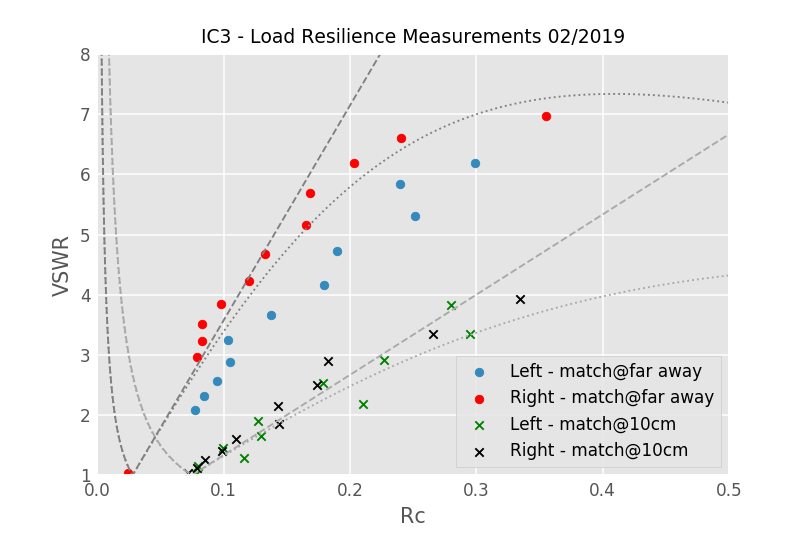

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, 'IC3 - Load Resilience Measurements 02/2019')

In [708]:

df_Left_Large_mean = df_Left_Large_Quad2#(df_Left_Large_Quad4 + df_Left_Large_Quad2)/2 # solution 1 pas terrible
df_Right_Large_mean =(df_Right_Large_Quad4 + df_Right_Large_Quad2)/2
df_Right_Large_mean = df_Right_Large_mean.append(df_Right_Large_Quad4_faraway)

df_Left_10cm_mean = df_Left_10cm_Quad2 # (df_Left_10cm_Quad4 + df_Left_10cm_Quad2)/2
df_Right_10cm_mean = (df_Right_10cm_Quad4 + df_Right_10cm_Quad2)/2


fig, ax = plt.subplots()
df_Left_Large_mean.plot(kind='scatter', x='Rc', y='VSWR', ax=ax, label='Left - match@far away')
df_Right_Large_mean.plot(kind='scatter', x='Rc', y='VSWR', ax=ax, label='Right - match@far away', color='r')

df_Left_10cm_mean.plot(kind='scatter', x='Rc', y='VSWR', ax=ax, label='Left - match@10cm', color='g', marker='x')
df_Right_10cm_mean.plot(kind='scatter', x='Rc', y='VSWR', ax=ax, label='Right - match@10cm', color='k', marker='x')

Rcs = np.linspace(0, 0.5, num=5001)

Rc0_10cm = 75e-3
alpha = Rcs/Rc0_10cm
k = 3/Rc0_10cm

ax.plot(Rcs, (Rcs<Rc0_10cm)*Rc0_10cm/Rcs + (Rcs>=Rc0_10cm)*Rcs/Rc0_10cm, ls='--', color='darkgrey')
ax.plot(Rcs, (Rcs<Rc0_10cm)*( (alpha**2 +2*k-1)/(2*k*alpha)) + 
        (Rcs>=Rc0_10cm)*1/( (alpha**2 +2*k-1)/(2*k*alpha)) , ls=':', color='darkgrey')


Rc0_Large = 28e-3
alpha = Rcs/Rc0_Large
k = 3/Rc0_Large

ax.plot(Rcs, (Rcs<Rc0_Large)*Rc0_Large/Rcs + (Rcs>=Rc0_Large)*Rcs/Rc0_Large, ls='--', color='grey')
ax.plot(Rcs, (Rcs<Rc0_Large)*( (alpha**2 +2*k-1)/(2*k*alpha)) + 
        (Rcs>=Rc0_Large)*1/( (alpha**2 +2*k-1)/(2*k*alpha)) , ls=':', color='grey')

ax.set_xlim(0, 0.5)
ax.set_ylim(1, 8)
ax.set_title('IC3 - Load Resilience Measurements 02/2019', fontsize=10)

In [709]:
fig.savefig('IC3_VSWR_vs_Rc_all.png', dpi=150)

## Left side in TITAN

In [20]:
ntw = rf.Network('Sparameters/LowPowerTestsAquarium/Left/Matching_every_Daq/IC3_Left_55p5MHz_DaqMLarge_2.s4p', f_unit='MHz')

idx = np.argmin(np.abs(ntw.s[:,0,0]))
f0 = ntw.f[idx]
print('match frequency:', f0/1e6, ' MHz')
print('Sii [dB]:', 20*np.log10(np.abs(ntw.s[idx,0,0])))
print('VSWR :', ntw.s_vswr[idx,0,0])

R = extract_Rc(ntw, A=np.r_[1,0,0,0], f0=f0)
print('R :', R[idx])

match frequency: 55.50125  MHz
Sii [dB]: -50.29085640067849
VSWR : 1.0061350392189994
R : [ 2.67374447e-02 -8.73236059e-06]


<IPython.core.display.Javascript object>


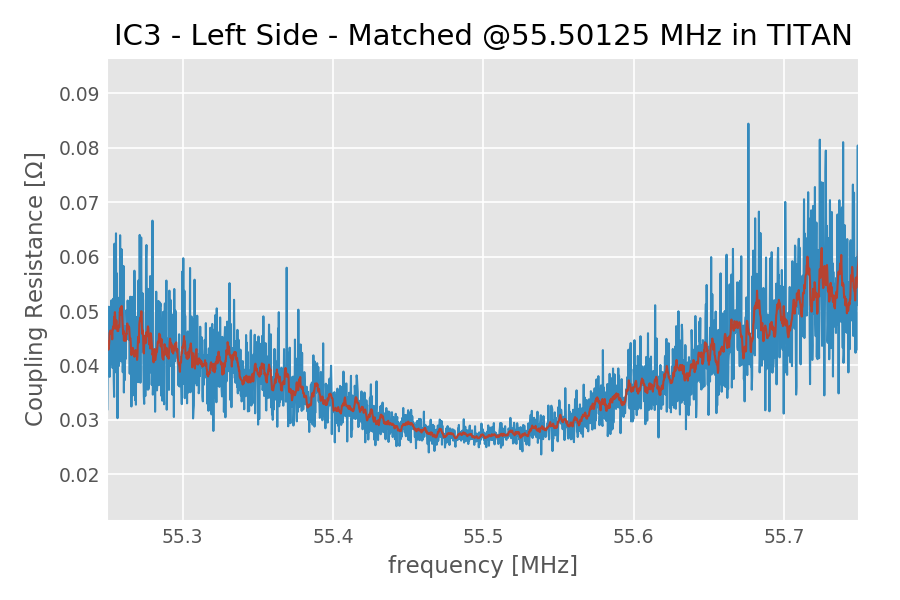

In [18]:
fig, ax = plt.subplots()
ax.plot(left.f/1e6, R[:,0])
ax.plot(left.f/1e6, rf.smooth(R[:,0]))
ax.set_ylabel('Coupling Resistance [$\Omega$]')
ax.set_xlabel('frequency [MHz]')
ax.set_title(f'IC3 - Left Side - Matched @{f0/1e6} MHz in TITAN', fontsize=14)

fig.tight_layout()
#fig.savefig('IC3_Left_Matched55.5MHz_TITAN_Rc.png', dpi=150)

## Left side

In [401]:
ntw = rf.Network('Sparameters/LowPowerTestsAquarium/Left/Matching_every_Daq/IC3_Left_55p5MHz_DaqM10p0cm_2.s4p', f_unit='MHz')

idx = np.argmin(np.abs(ntw.s[:,0,0]))
f0 = ntw.f[idx]
print('match frequency:', f0/1e6, ' MHz')
print('Sii [dB]:', 20*np.log10(np.abs(ntw.s[idx,0,0])))
print('VSWR :', ntw.s_vswr[idx,0,0])

R = extract_Rc(ntw, A=np.r_[1,0,0,0], f0=f0)
print('R :', R[idx])

match frequency: 55.50125  MHz
Sii [dB]: -52.56475672722694
VSWR : 1.0047186263564358
R : [ 7.81716507e-02 -2.10325343e-05]


<IPython.core.display.Javascript object>


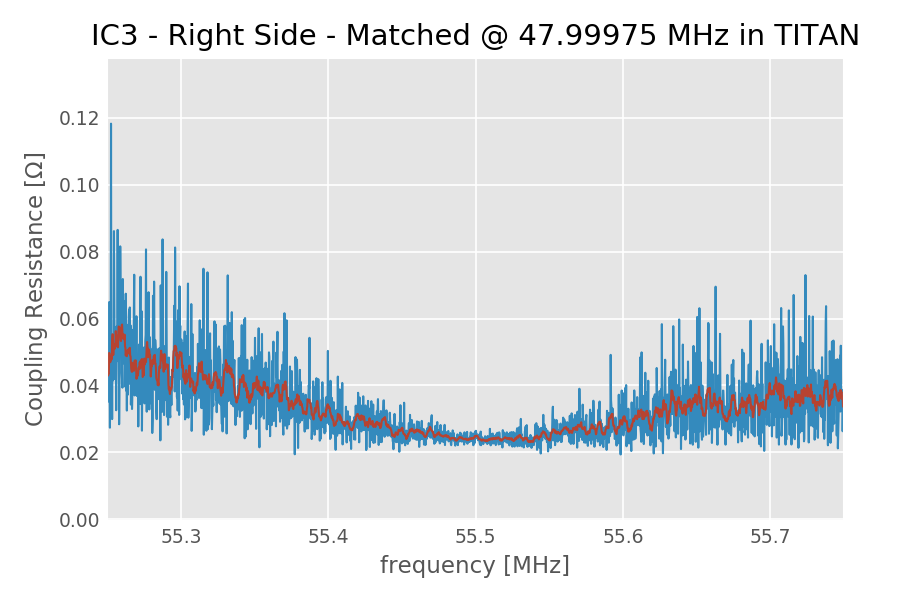

In [98]:
fig, ax = plt.subplots()
ax.plot(right.f/1e6, R[:,1])
ax.plot(right.f/1e6, rf.smooth(R[:,1]))
ax.set_ylabel('Coupling Resistance [$\Omega$]')
ax.set_xlabel('frequency [MHz]')
ax.set_title(f'IC3 - Right Side - Matched @ {f0/1e6} MHz in TITAN', fontsize=14)

fig.tight_layout()
#fig.savefig('IC3_Right_Matched55.5MHz_TITAN_Rc.png', dpi=150)

# Error Adapter

Importing Walid's calculation of the scattering parameters of the combination of coaxial adapter and impedance transformer

In [25]:
# This is the chain matrix (ABCD) of the error box, Port 1 is 50ohm side, Port 2 is 30ohm 9inch side
error_adapter = loadmat('Error Adapter/T_errorbox.mat')
error_adapter

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jan 11 12:16:14 2019',
 '__version__': '1.0',
 '__globals__': [],
 'T11': array([[ 0.83816247-2.95942523e-10j,  0.84324803+0.00000000e+00j,
          0.84834366+3.59127990e-16j, ..., -0.14844734+2.92271134e-16j,
         -0.14844734+2.92271134e-16j, -0.14844734+2.92271134e-16j]]),
 'T12': array([[ 5.66741113e-09-30.79138879j,  0.00000000e+00-30.68287893j,
         -6.89525741e-15-30.57947027j, ..., -2.17926438e-15+39.10265269j,
         -2.17926438e-15+39.10265269j, -2.17926438e-15+39.10265269j]]),
 'T21': array([[ 7.52828755e-12-0.02025971j,  0.00000000e+00-0.02015499j,
         -4.48909987e-18-0.0200479j , ..., -7.09395956e-19+0.02504893j,
         -7.09395956e-19+0.02504893j, -7.09395956e-19+0.02504893j]]),
 'T22': array([[ 0.44880969-2.55087439e-10j,  0.4525203 -7.21382839e-17j,
          0.45611908+1.07738397e-16j, ..., -0.13823327+1.53229527e-16j,
         -0.13823327+1.53229527e-16j, -0.13823327+1.53229527e

In [26]:
# converting the ABCD matrix into skrf Network
A11 = error_adapter['T11'].squeeze()
A12 = error_adapter['T12'].squeeze()
A21 = error_adapter['T21'].squeeze()
A22 = error_adapter['T22'].squeeze()

# creating a (2,2) matrix for all the N frequencies (2,2,N)
# pays attention that A21 is volontary transposed with A12
# in order to be at the correct position after swaping the axes after
# (1st dimension in Numpy along rows!)
A = np.array([[A11, A21],
              [A12, A22]])
# (2,2,N) -> (N,2,2) 
A = A.swapaxes(2,0)

# transforming to S matrices
S = rf.network.a2s(A, z0=50)

# converting the transmission parameters to skrf Network
freq = rf.Frequency.from_f(error_adapter['fMHz'].squeeze(), unit='MHz')
err = rf.Network(s=S, frequency=freq, z0=50, name="error adapter")


<IPython.core.display.Javascript object>


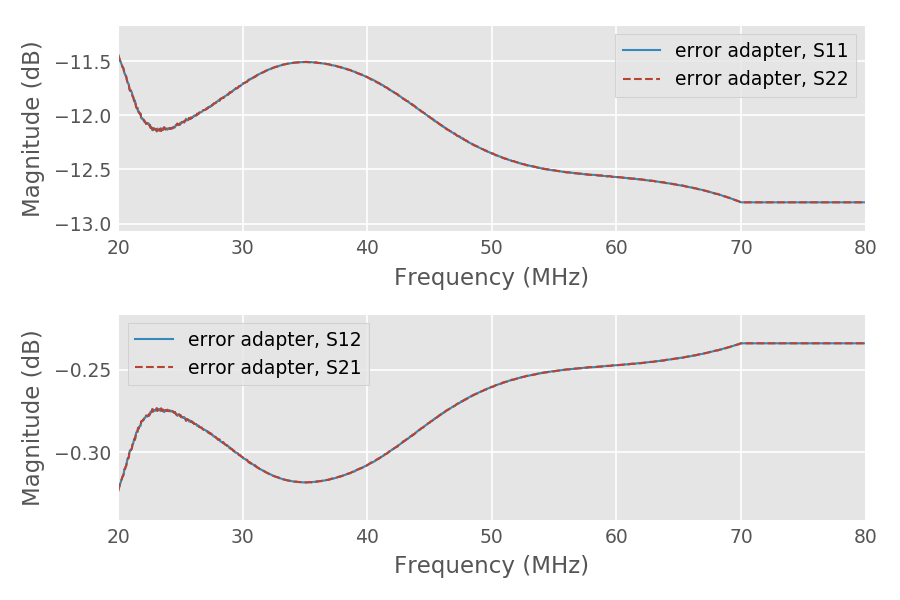

In [27]:
fig, axes = plt.subplots(2,1)
err.plot_s_db(ax=axes[0], m=0, n=0)
err.plot_s_db(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_db(ax=axes[1], m=0, n=1)
err.plot_s_db(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()

<IPython.core.display.Javascript object>


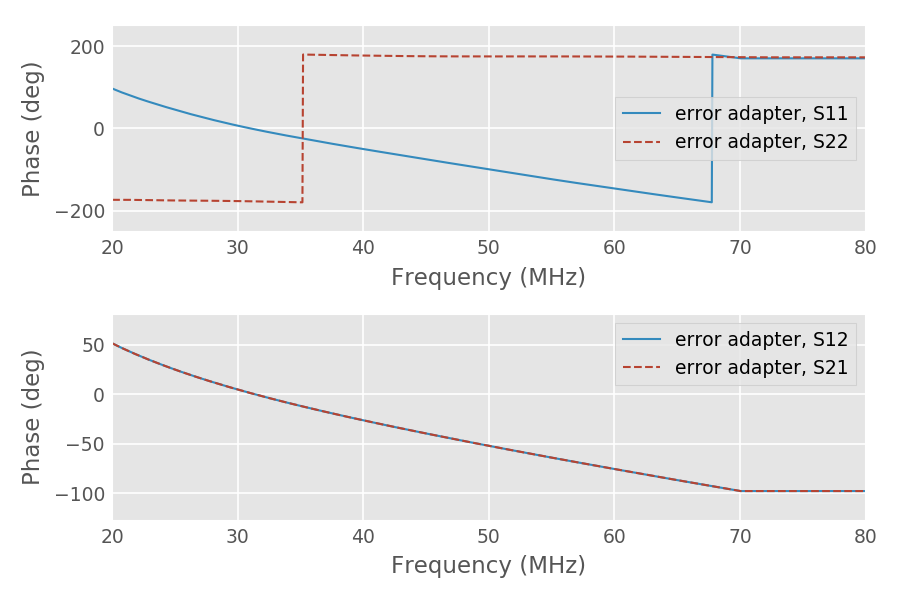

In [28]:
fig, axes = plt.subplots(2,1)
err.plot_s_deg(ax=axes[0], m=0, n=0)
err.plot_s_deg(ax=axes[0], m=1, n=1, ls='--')

err.plot_s_deg(ax=axes[1], m=0, n=1)
err.plot_s_deg(ax=axes[1], m=1, n=0, ls='--')
fig.tight_layout()